# Analytics for Unstructured Data: Group Assignment #1

Akshay Navaneetha Krishnan (an34244)  
Bhuvana Chandrika Kothapalli (bk24542)  
Dinesh Bandaru (db46729)  
Ashwanth Draksha (ad55293)  
Jahnavi Angati (ja54632)

In this assignment you have been hired as an analytics consultant by JD power and Associates, who wants to perform a competitive analysis of the entry level luxury car market in the USA. Your job is to give advice/insights to your client based on the analysis of social media conversations. The detailed tasks
are described below.
Note: You DON’T have to do a sentiment analysis for this assignment. You can assume that all sentiments are positive.

In [1]:
# Importing libraries

!pip install selenium
!apt-get -q update   #Used to handle installation and removal of softwares and libraries
!apt install -yq chromium-chromedriver #ChromeDriver is a separate executable that Selenium WebDriver uses to control Chrome.
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0,'/usr/lib/chromium-browser/chromedriver')
from selenium import webdriver
from selenium.webdriver.common.by import By
#WebDriver is a browser automation framework that works with open source APIs.
#The framework operates by accepting commands, sending those commands to a browser, and interacting with applications.
chrome_options = webdriver.ChromeOptions()
#headless means running chrome with chrome.exe
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

import pandas as pd
import string
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn.linear_model import LinearRegression
from scipy import stats
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from collections import defaultdict
from itertools import combinations
from sklearn.manifold import MDS
from itertools import product
import seaborn as sns
from google.colab import files

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.2/400.2 kB 28.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.2 MB/s eta 0:00:00
Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:4 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [497 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.ne

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
wd = webdriver.Chrome(options=chrome_options)
wd.get("https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans")

In [3]:
pageDf = pd.DataFrame(columns=['Date','Message'])
def crawler(pageNumber):
    print('Parsing Page Number {}'.format(pageNumber))
    pageString = '/p{}'
    urlString='https://forums.edmunds.com/discussion/2864/general/x/entry-level-luxury-performance-sedans'
    if(int(pageNumber)>1):
        urlString = urlString+pageString.format(pageNumber)
    wd.get(urlString)

    #Get the whole comment box including the page numbers in one element
    totalElements = wd.find_element(by=By.CLASS_NAME,value='CommentsWrap')

    #Extract the comments box
    elements = totalElements.find_elements(by=By.CLASS_NAME,value='Comment')
    pagingDf =  parsePage(elements,pageDf)

    #Extract the next page number boxes
    pageElements = totalElements.find_element(by=By.CLASS_NAME,value='P.PagerWrap')
    hrefs = pageElements.find_elements(by=By.TAG_NAME,value='a')
    print('Parsing Completed for Page Number {}'.format(pageNumber))

    #Find the index of the current page and see if it's the last page of the scraper
    pageList = [x.text for x in hrefs]
    pageIndex = pageList.index(pageNumber)

    #Last page will not have a next pagenumber, so we need to break the recursion call there
    if(len(hrefs[pageIndex+1].text)==0):
        return pagingDf
    else:
        next_page = hrefs[pageIndex+1].text
        print ('Next Page : {}'.format(next_page))
        return crawler(next_page)

#### Removing blockquote texts

In [4]:
import datetime
import logging
from selenium.webdriver.common.by import By

# Configure logging
logging.basicConfig(filename='parsing.log', level=logging.ERROR)  # Log errors to a file

def parsePage(pageElement, pageDf):
    for element in pageElement:
        userComment = ''

        try:
            # For blockquote texts, we should remove the duplicate comments while keeping the earlier comments, hence replacing that string with blanks
            if len(element.find_elements(by=By.CLASS_NAME, value='blockquote')) > 0:
                blockquoteText = element.find_element(by=By.CLASS_NAME, value='blockquote').text
                elementText = element.find_element(by=By.CLASS_NAME, value='Message.userContent').text
                userComment = elementText.replace(blockquoteText, '').strip()
            else:
                userComment = element.find_element(by=By.CLASS_NAME, value='Message.userContent').text.strip()

            timeElement = element.find_element(by=By.TAG_NAME, value='time')
            date = timeElement.get_attribute('title')

            # Get the date in a specific format
            tempDate = datetime.datetime.strptime(date, '%B %d, %Y %I:%M%p')
            time = tempDate.strftime("%Y-%m-%d %H:%M:%S")
            pageDf.loc[len(pageDf.index)] = [time, userComment]

        except Exception as e:
            # Log the error message
            logging.error(f"Error processing element: {e}")

    return pageDf

#### Scraping the latest 5000 comments i.e., from 335-435 pages.

In [5]:
df = crawler('335')

Parsing Page Number 335
Parsing Completed for Page Number 335
Next Page : 336
Parsing Page Number 336
Parsing Completed for Page Number 336
Next Page : 337
Parsing Page Number 337
Parsing Completed for Page Number 337
Next Page : 338
Parsing Page Number 338
Parsing Completed for Page Number 338
Next Page : 339
Parsing Page Number 339
Parsing Completed for Page Number 339
Next Page : 340
Parsing Page Number 340
Parsing Completed for Page Number 340
Next Page : 341
Parsing Page Number 341
Parsing Completed for Page Number 341
Next Page : 342
Parsing Page Number 342
Parsing Completed for Page Number 342
Next Page : 343
Parsing Page Number 343
Parsing Completed for Page Number 343
Next Page : 344
Parsing Page Number 344
Parsing Completed for Page Number 344
Next Page : 345
Parsing Page Number 345
Parsing Completed for Page Number 345
Next Page : 346
Parsing Page Number 346
Parsing Completed for Page Number 346
Next Page : 347
Parsing Page Number 347
Parsing Completed for Page Number 347
Ne

In [6]:
df.head(10)

,Date,Message
0,2014-02-25 18:50:00,@roadburner\nYou hit the nail on the head. You...
1,2014-02-25 19:09:00,now that I have inherited my Acura TL back (a ...
2,2014-02-25 19:25:00,@stickguy\nEven with the coil packs you had to...
3,2014-02-26 10:59:00,@nyccarguy\nExactly. You have to evaluate all ...
4,2014-02-26 11:14:00,Heresy if repeated over on Chronic Car Buyers!...
5,2014-02-26 11:52:00,Which Lexus model is this?
6,2014-02-26 12:38:00,"$1200/yr is a very sober estimate and IMO, ver..."
7,2014-02-26 12:45:00,My TL even with all the miles has not averaged...
8,2014-02-26 13:01:00,Here's something to make your blood run cold:\...
9,2014-02-26 13:04:00,might have run up around that much.\nOf course...


In [7]:
df.to_csv('Scrapedcomments.csv',index=False)

#### **Task A:**
#### Once you fetch the data, test if the data support Zipf’s law econometrically. Additionally plot the most common 100 words in the data against the theoretical prediction of the law. For this question, do not remove stopwords. Also do not perform stemming or lemmatization.

In [8]:
df['Message'] = df['Message'].astype(str)
df['Message'] = df['Message'].str.lower()
# Function to remove punctuation from a string
def remove_punctuation(text):
    translator = str.maketrans(' ', ' ', string.punctuation)
    return text.translate(translator)

def remove_newline(text):
  text = text.replace('\n',' ')
  return text

# Function to remove extra spaces
def remove_extra_spaces(text):
    text = ' '.join(text.split())
    return text

df['Message'] = df['Message'].apply(remove_punctuation)
df['Message'] = df['Message'].apply(remove_newline)
df['Message'] = df['Message'].apply(remove_extra_spaces)

# Remove entries with empty or whitespace-only 'Message' column
df = df[df['Message'].str.strip() != '']

# Reset the index of the DataFrame after removing rows
df.reset_index(drop=True, inplace=True)

df.head(5)

,Date,Message
0,2014-02-25 18:50:00,roadburner you hit the nail on the head you bu...
1,2014-02-25 19:09:00,now that i have inherited my acura tl back a 2...
2,2014-02-25 19:25:00,stickguy even with the coil packs you had to r...
3,2014-02-26 10:59:00,nyccarguy exactly you have to evaluate all you...
4,2014-02-26 11:14:00,heresy if repeated over on chronic car buyers ...


In [9]:
df['Message'] = df['Message'].astype(str)
# Concatenate all messages into a single text corpus
corpus = " ".join(df['Message'])

# Tokenize the text into words (simple split by space)
words = corpus.split()

# Calculate word frequencies
word_freq = Counter(words)

# Get the 100 most common words
top_words = word_freq.most_common(100)
top_words

<ipython-input-9-75529937975f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Message'] = df['Message'].astype(str)


[('the', 24145),
 ('a', 11533),
 ('to', 10081),
 ('and', 9853),
 ('i', 9171),
 ('of', 7418),
 ('is', 6241),
 ('in', 5928),
 ('that', 5691),
 ('it', 5600),
 ('for', 4731),
 ('with', 3836),
 ('on', 3483),
 ('you', 3400),
 ('but', 3356),
 ('my', 3088),
 ('have', 2960),
 ('be', 2840),
 ('not', 2734),
 ('car', 2715),
 ('was', 2666),
 ('as', 2612),
 ('are', 2568),
 ('at', 2511),
 ('they', 2485),
 ('or', 2345),
 ('if', 1959),
 ('an', 1914),
 ('so', 1795),
 ('this', 1782),
 ('like', 1738),
 ('would', 1733),
 ('cars', 1639),
 ('one', 1591),
 ('more', 1585),
 ('its', 1535),
 ('just', 1489),
 ('has', 1422),
 ('about', 1403),
 ('all', 1367),
 ('will', 1291),
 ('than', 1281),
 ('bmw', 1278),
 ('get', 1276),
 ('new', 1267),
 ('from', 1265),
 ('can', 1256),
 ('me', 1256),
 ('had', 1252),
 ('what', 1228),
 ('we', 1181),
 ('up', 1151),
 ('no', 1108),
 ('out', 1102),
 ('some', 1092),
 ('think', 1081),
 ('even', 1057),
 ('there', 1050),
 ('audi', 1040),
 ('when', 1026),
 ('their', 992),
 ('do', 988),
 ('

After performing some data preprocessing, we have obtained a list of the 100 most frequently occurring words. Our next step is to visualize their frequencies and calculate the Zipf frequency, which represents the ratio of a word's frequency to the total corpus frequency. During the cleaning process, we focused on tasks such as removing punctuation, eliminating extra spaces, and converting the text to lowercase.

<ipython-input-10-5ed26ea81a0a>:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data=plot_df, x='Word', y='Frequency', palette='coolwarm', ci=None)


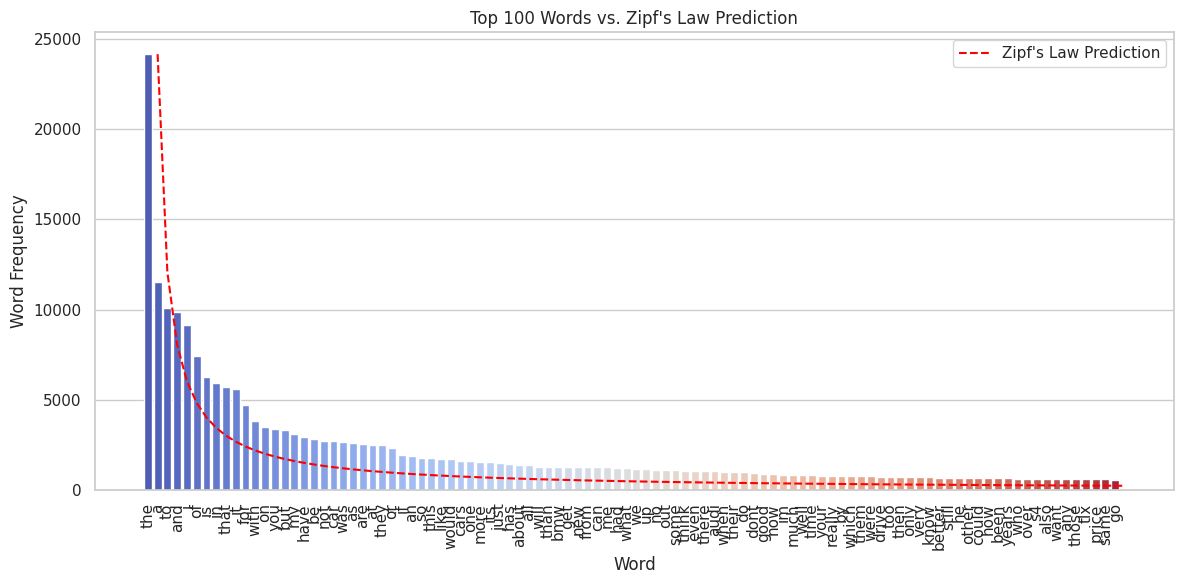

In [10]:
# Create a DataFrame for plotting
plot_df = pd.DataFrame({'Word': [word[0] for word in top_words], 'Frequency': [word[1] for word in top_words]})

# Calculate the rank of each word (words are already sorted by frequency)
plot_df['Rank'] = range(1, len(plot_df) + 1)

# Calculate the theoretical prediction of Zipf's law
max_frequency = plot_df['Frequency'].max()
zipf_prediction = [max_frequency / rank for rank in plot_df['Rank']]

# Create a Seaborn bar plot with 'coolwarm' colormap
plt.figure(figsize=(12, 6))
sns.set(style="whitegrid")  # Turn off the gradient background
ax = sns.barplot(data=plot_df, x='Word', y='Frequency', palette='coolwarm', ci=None)
plt.plot(plot_df['Rank'], zipf_prediction, color='red', linestyle='--', label='Zipf\'s Law Prediction')
plt.xlabel('Word')
plt.ylabel('Word Frequency')
plt.title('Top 100 Words vs. Zipf\'s Law Prediction')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()  # Ensure proper spacing of labels
plt.show()

<ipython-input-11-1d16afb219c2>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = plt.cm.get_cmap('coolwarm', 1)


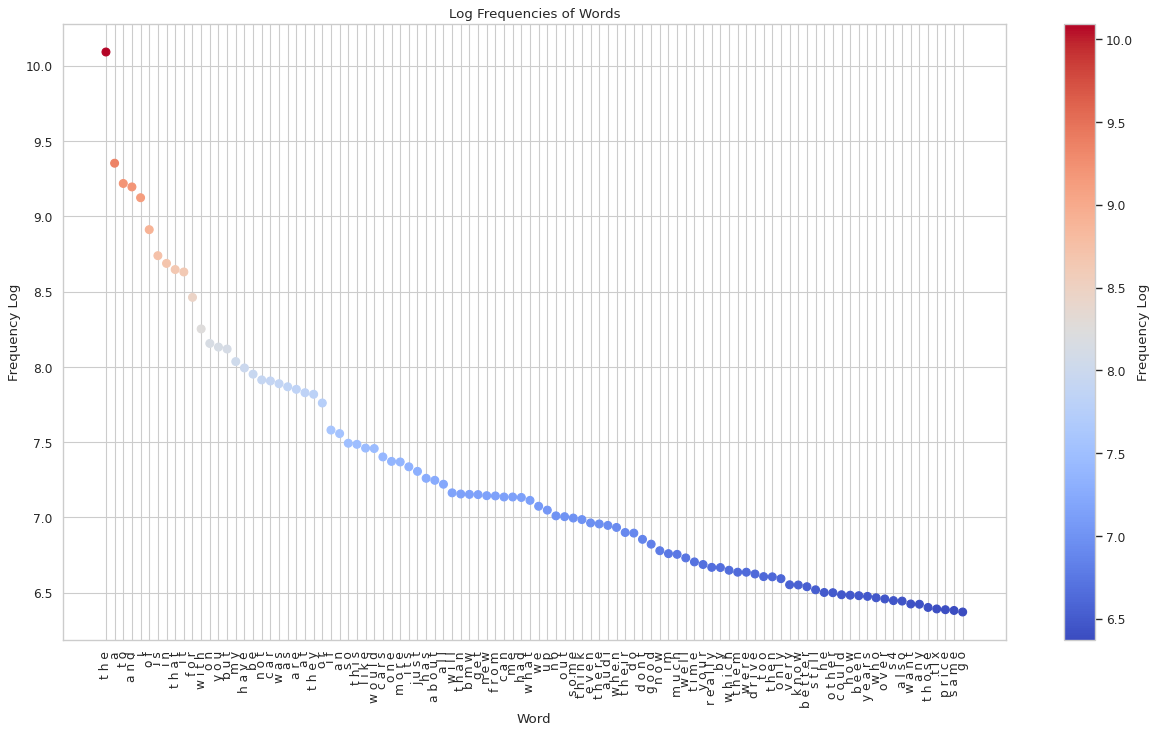

In [11]:
import matplotlib.pyplot as plt
import math
import pandas as pd
import numpy as np

# Create a DataFrame from your data
word_count = pd.DataFrame(data=top_words, columns=['word', 'frequency'])

# Calculate the logarithm of the frequency
word_count['log_freq'] = word_count['frequency'].apply(lambda x: math.log(int(x)))

# Convert list to string
word_count['word'] = word_count['word'].apply(' '.join)

# Create a colormap for the scatter plot (using 'coolwarm' colormap for a color gradient)
colormap = plt.cm.get_cmap('coolwarm', 1)

# Plot word count graph with a scatter plot and color gradient
plt.figure(figsize=(19, 10), dpi=80)
plt.scatter(word_count['word'], word_count['log_freq'], c=word_count['log_freq'], cmap='coolwarm', s=50)
plt.title('Log Frequencies of Words')
plt.xlabel('Word')
plt.ylabel('Frequency Log')
plt.xticks(rotation=90)

# Add a colorbar for reference
colorbar = plt.colorbar()
colorbar.set_label('Frequency Log', rotation=90)

plt.show()

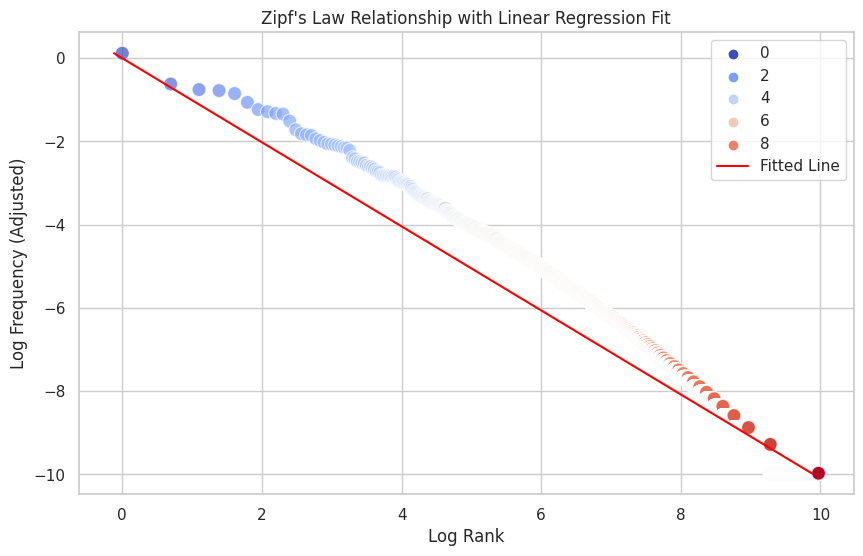

In [13]:
# Testing is the data supports Zipf's law econometrically

zipfs_testing = pd.DataFrame({'ranks': list(range(1, len(word_freq.most_common()) + 1)),'frequency':[word[1] for word in word_freq.most_common()]})
zipfs_testing['log_rank'] = np.log(zipfs_testing['ranks'])
zipfs_testing['log_frequency_adjusted'] = np.log(zipfs_testing['frequency'] / (zipfs_testing['ranks'].iloc[-1] * zipfs_testing['frequency'].iloc[-1]))

X=zipfs_testing[['log_frequency_adjusted']]
Y=zipfs_testing[['log_rank']]

# Create a LinearRegression model
model = LinearRegression(fit_intercept=False)

# Fit the model with 'log_frequency_adjusted' as the independent variable and 'log_rank' as the dependent variable
model.fit(X, Y)

# Get the coefficients and intercept of the model
coef = model.coef_[0]
intercept = model.intercept_

# Create a scatter plot of the original data points using a Seaborn colormap
plt.figure(figsize=(10, 6))
sns.scatterplot(data=zipfs_testing, x='log_rank', y='log_frequency_adjusted', hue='log_rank', palette='coolwarm', s=100, alpha=0.7)

# Plot the fitted regression line
plt.plot( model.predict(X),X, color='red', label='Fitted Line')

plt.xlabel('Log Rank')
plt.ylabel('Log Frequency (Adjusted)')
plt.title('Zipf\'s Law Relationship with Linear Regression Fit')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# Define your hypothesized value
hypothesized_value = -1

# Calculate the standard error of the coefficient estimate
standard_error_of_residuals = (((Y - model.predict(X))**2).mean()**0.5).item()
sum_of_squared_deviation_of_X_from_mean = np.sum((X - X.mean())**2).item()
standard_error = standard_error_of_residuals / np.sqrt(sum_of_squared_deviation_of_X_from_mean)

# Calculate the z-statistic (assuming a normal distribution)
z_statistic = (coef[0] - hypothesized_value) / standard_error

# Calculate the p-value (two-tailed)
p_value = 2 * (1 - stats.norm.cdf(abs(z_statistic)))

# Print z-statistic and p-values
print("z-Statistic:", z_statistic)
print("P-Values:", p_value)

print(f"\nWe must reject the null hypothesis that the true coefficient (theta value) is -1, however, for all effects and purposes, the coefficient value of {coef.item()} is close enough to -1 that we can say that zipf's law is valid in this case (assuming a normal distribution)")

z-Statistic: 5.046535188259323
P-Values: 4.4989406533524345e-07

We must reject the null hypothesis that the true coefficient (theta value) is -1, however, for all effects and purposes, the coefficient value of -0.9901580911280956 is close enough to -1 that we can say that zipf's law is valid in this case (assuming a normal distribution)


#### **Task B:**
Find the top 10 brands from frequency counts. You will need to write a script to count the frequencies of words (stopwords should NOT be counted). Replace frequently occurring car models with brands so that from now on you have to deal with only brands and not models. You will need another script for this job. A list of model and brand names (not exhaustive) are provided in a separate file. Even if a brand (e.g., BMW) is mentioned multiple times in a message, it should be counted as 1.

In [15]:
from google.colab import drive
from google.colab import files
uploaded = files.upload()
model_brand=pd.read_csv('car_models_and_brands.csv')
model_brand['Model'] = model_brand['Model'].str.lower()
model_brand['Brand'] = model_brand['Brand'].str.lower()

Saving car_models_and_brands.csv to car_models_and_brands.csv


In [16]:
# Tokenizing the words in messages
df['Tokens'] = df['Message'].apply(nltk.word_tokenize)

# Removing the stop words
stop_words = set(stopwords.words('english'))
df['Tokens'] = df['Tokens'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])

# Function to replace the model with brand name
def replace_models_with_brands(x):
    i = 0
    replaced_tokens = []

    while i < len(x):
        brand_match = model_brand[model_brand['Model'] == x[i]]
        if not brand_match.empty:
            replaced_tokens.append(brand_match.iloc[0]['Brand'])
        else:
            replaced_tokens.append(x[i])
        i += 1
    return replaced_tokens

df['Tokens'] = df['Tokens'].apply(replace_models_with_brands)

# Removing redundant brands
brands_to_exclude = ['car', 'problem', 'seat','sedan']
filtered_brand_list = [brand for brand in model_brand["Brand"].unique() if brand not in brands_to_exclude]

<ipython-input-16-df541cc48690>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df['Message'].apply(nltk.word_tokenize)
<ipython-input-16-df541cc48690>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Tokens'] = df['Tokens'].apply(lambda tokens: [word.lower() for word in tokens if word.lower() not in stop_words])
<ipython-input-16-df541cc48690>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [17]:
# Create a defaultdict to count messages for each brand
brand_message_count = defaultdict(int)

# Iterate through the 'Tokens' column and count messages for each brand
for tokens in df['Tokens']:
    # Use a set to keep track of unique brands in each message
    unique_brands_in_message = set()

    for token in tokens:
        if token in filtered_brand_list:
            unique_brands_in_message.add(token)

    # Increment the message count for each unique brand in the message
    for brand in unique_brands_in_message:
        brand_message_count[brand] += 1

# Convert the defaultdict to a DataFrame for easy analysis
brand_message_count_df = pd.DataFrame({'Brand': list(brand_message_count.keys()), 'Message_Count': list(brand_message_count.values())})

# Sort the DataFrame by message count in descending order
brand_message_count_df = brand_message_count_df.sort_values(by='Message_Count', ascending=False)

# Print the top 10 brands by message count
top_10_brands = brand_message_count_df.head(11).reset_index(drop=True)
#top_10_brands[:10]

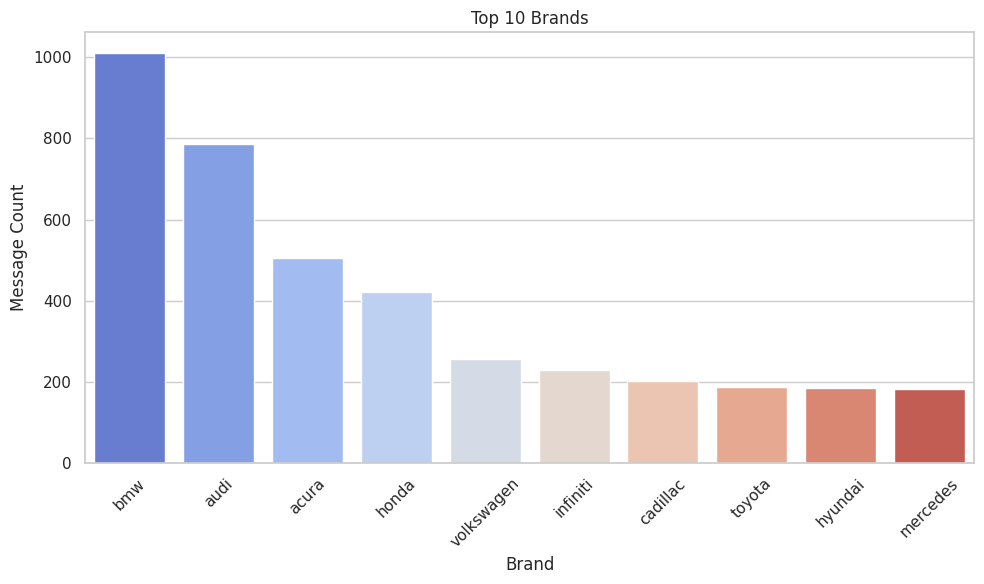

In [18]:
# Plot the top 10 brands
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")  # Turn off the gradient background
sns.barplot(data=top_10_brands.head(10), x='Brand', y='Message_Count', palette='coolwarm')
plt.xlabel('Brand')
plt.ylabel('Message Count')
plt.title('Top 10 Brands')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.tight_layout()  # Ensure proper spacing of labels

plt.show()

#### **Task C:**
 Calculate lift ratios for associations between the top-10 brands identified in Task A. You will have to write a script to do this task. For lift calculations, be sure not to count a mention more than once per post, even if it is mentioned multiple times in the post. In your code, ensure that a message is not counted in the lift calculations if the mentions of two brands are separated by more than, say, 5 or 7 words.

In [19]:
# Making all possible combinations of brands
all_combinations = list(combinations(top_10_brands["Brand"], 2))
df_combinations = pd.DataFrame(all_combinations, columns=["Brand1", "Brand2"])
df_combinations.head(10)

,Brand1,Brand2
0,bmw,audi
1,bmw,acura
2,bmw,honda
3,bmw,volkswagen
4,bmw,infiniti
5,bmw,cadillac
6,bmw,toyota
7,bmw,hyundai
8,bmw,mercedes
9,bmw,ford


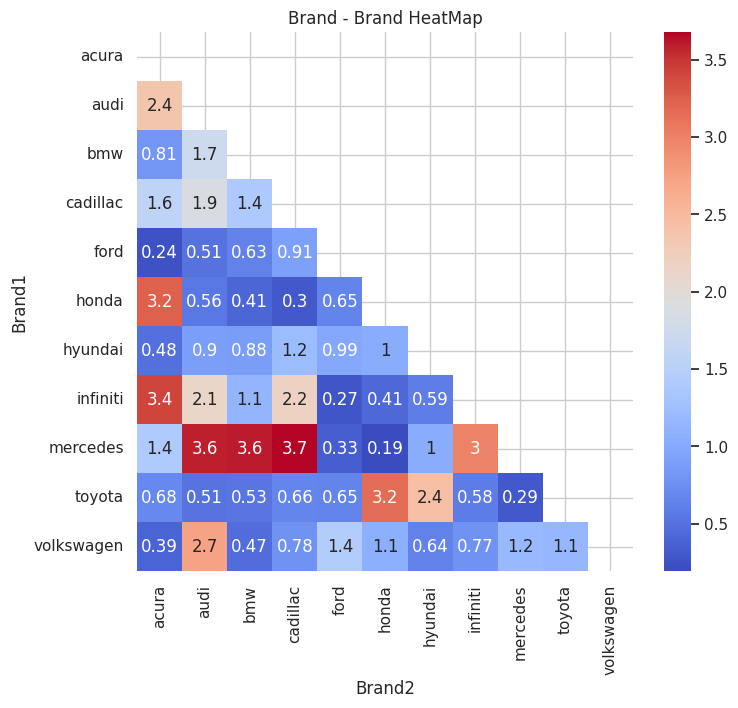

In [20]:
# Initialize an empty DataFrame to store results
result_columns = ['Brand1', 'Brand2', 'Brand1_Count', 'Brand2_Count', 'Brand1_Brand2_Cooccurrence_Count', 'Total_Messages']
result_df = pd.DataFrame(columns=result_columns)

# Calculate the total number of messages
total_messages = len(df['Tokens'])

# Loop through all combinations of brands
for brand_pair in df_combinations.itertuples(index=False):
    brand1, brand2 = brand_pair

    # Initialize Counters and Position Tracker
    count_brand1 = 0
    count_brand2 = 0
    count_cooccurrence = 0

    # Loop over messages
    for tokens in df['Tokens']:
        # Check total messages with Brand1
        if brand1 in tokens:
            count_brand1 += 1

        # Check total messages with Brand2
        if brand2 in tokens:
            count_brand2 += 1

        # Check for Co-occurrence within the same message (not more than 5 tokens apart)
        if brand1 in tokens and brand2 in tokens:
            indices_brand1 = [i for i, token in enumerate(tokens) if token == brand1]
            indices_brand2 = [i for i, token in enumerate(tokens) if token == brand2]

            for index1 in indices_brand1:
                for index2 in indices_brand2:
                    if abs(index1 - index2) <= 8:
                        count_cooccurrence += 1
                        break  # Break once co-occurrence is found in this message

    # Append results to the DataFrame
    result_df = pd.concat([result_df, pd.DataFrame({'Brand1': [brand1], 'Brand2': [brand2],
                                  'Brand1_Count': [count_brand1],
                                  'Brand2_Count': [count_brand2],
                                  'Brand1_Brand2_Cooccurrence_Count': [count_cooccurrence],
                                  'Total_Messages': [total_messages]})],
                          ignore_index=True)
result_df["lift"]=(result_df["Brand1_Brand2_Cooccurrence_Count"]/result_df["Total_Messages"])/((result_df["Brand1_Count"]/result_df["Total_Messages"])*(result_df["Brand2_Count"]/result_df["Total_Messages"]))

# Sort result_df by "lift" column in descending order
result_df_sorted = result_df.sort_values(by=['Brand1','Brand2'], ascending=False)
#result_df_sorted

# Create a new DataFrame with 'Brand1' and 'Brand2' columns swapped
new_df = result_df_sorted.copy()  # Make a copy of result_df to avoid modifying it directly
new_df['Brand1'], new_df['Brand2'] = new_df['Brand2'], new_df['Brand1']

# Append the new DataFrame to result_df
result_df_sorted = pd.concat([result_df_sorted, new_df], ignore_index=True)



# Creating a pivot to plot a HeatMap for Brand vs Attribute
pivot_df = result_df_sorted.pivot_table(index='Brand1',columns='Brand2',values='lift',aggfunc='max')
mask = np.triu(np.ones_like(pivot_df, dtype=bool))
plt.figure(figsize=(8, 7))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm',mask=mask)
plt.title('Brand - Brand HeatMap')
plt.show()

#### **Task D:**
Show the brands on a multi-dimensional scaling (MDS) map (use a Python script for MDS, there are multiple scripts available on GitHub).

/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


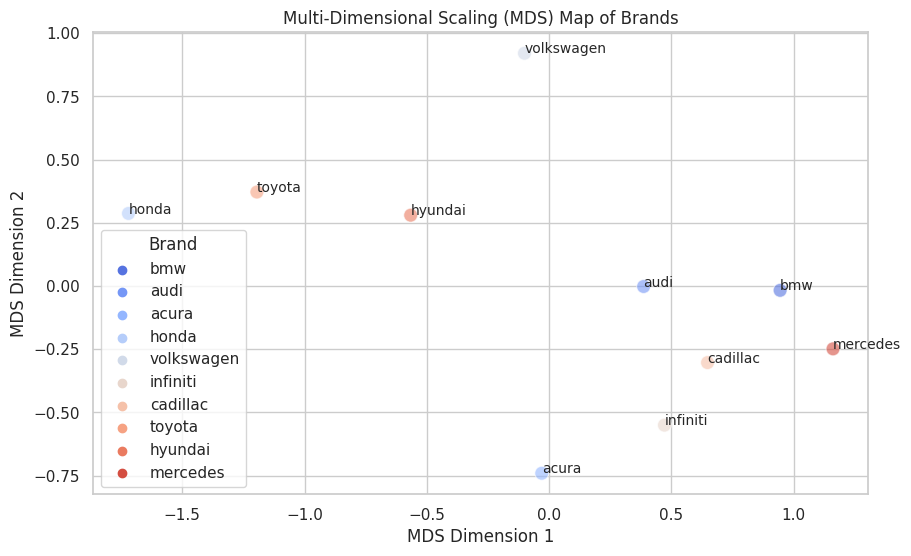

In [22]:
# Assuming you have a DataFrame called 'result_df' with lift ratios
brands = result_df['Brand1'].unique()
num_brands = len(brands)

# Create an empty square dissimilarity matrix
dissimilarity_matrix = np.zeros((num_brands, num_brands))

#pivot_df = pd.pivot_table(result_df, values='lift', index='Brand1', columns='Brand2', aggfunc='max')
#print(pivot_df)

# Calculate dissimilarity between all pairs of brands
for i in range(num_brands):
    for j in range(i+1, num_brands):
        brand1 = brands[i]
        brand2 = brands[j]

        dissimilarity = 1 / result_df.loc[(result_df['Brand1'] == brand1) & (result_df['Brand2'] == brand2), 'lift'].values[0]

        # Fill both symmetric positions in the matrix
        dissimilarity_matrix[i, j] = dissimilarity
        dissimilarity_matrix[j, i] = dissimilarity

# Initialize MDS with 2 components for a 2D map
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)

# Fit MDS and obtain 2D coordinates
mds_coordinates = mds.fit_transform(dissimilarity_matrix)

# Create a new DataFrame with brand names and MDS coordinates
mds_df = pd.DataFrame({'Brand': brands,
                        'X': mds_coordinates[:, 0],
                        'Y': mds_coordinates[:, 1]})


# Create the MDS map using Seaborn with 'coolwarm' colormap
plt.figure(figsize=(10, 6))
sns.scatterplot(data=mds_df, x='X', y='Y', hue='Brand', palette='coolwarm', s=100, alpha=0.6)
for i, brand in enumerate(mds_df['Brand']):
    plt.annotate(brand, (mds_df['X'][i], mds_df['Y'][i]), fontsize=10)
plt.xlabel('MDS Dimension 1')
plt.ylabel('MDS Dimension 2')
plt.title('Multi-Dimensional Scaling (MDS) Map of Brands')
plt.grid(True)
plt.show()

#### **Task E:**
What insights can you offer to your client from your analyses in Tasks C and D?



From the conversations on Edmunds we can draw the following insights:
* The top 10 brands that are most frequently mentioned are : Mercedes, BMW, Infiniti, Cadillac, Audi, Accura, Volkswagen, Hyundai, Toyota, Honda, Hyundai, the top 3 being, BMW, Audi and Acura.
* The brands **Mercedes, BMW, Audi, Cadillac and Infiniti** have have very high co-mentions amongst each other.
* There must be some high end model in economical brands such as Honda, Hyundai, Toyota and Volkswagen that in the publics opinion is a competitive model in the entry-level luxury segment.
* The Japanese and Korean brands "Honda", "Toyota" and "Hyundai" have high mentions amongst each other.
* Furthermore, the MDS plot reveals that "Hyundai," "Toyota," and "Honda" are closely clustered together. This observation aligns with expectations, as these brands are all considered affordable car brands and are frequently compared to one another in discussions.
* Volkswagen have some model(s) that is not frequently being compared with other competitors.

#### **Task F:**
What are 5 most frequently mentioned attributes or features of cars in the discussions? Which attributes are most strongly associated with which of these 5 brands? There is no need to plot the MDS plot for this question.

In [23]:
# Making a list for all tokens
all_tokens = []

# Should we take unique tokens?
for i in df['Tokens']:
  all_tokens += list(i)

# Writing the counts of tokens
all_tokens = pd.Series(all_tokens)
all_tokens = all_tokens.value_counts().to_frame()
all_tokens.to_csv('all_tokens.csv')

After analyzing the tokens, we have selected 4 positive attributes - luxury, performance, sport, love and 2 negative attributes - issues and problem

In [24]:
# Creating brand - attribute combination
brands = list(brands)
attributes = ['sport','performance','luxury','problem','issues','love']
combi = list(product(brands, attributes))
df_brand_attr = pd.DataFrame(combi, columns=["Brand", "Attribute"])
df_brand_attr.head(5)

,Brand,Attribute
0,bmw,sport
1,bmw,performance
2,bmw,luxury
3,bmw,problem
4,bmw,issues


In [25]:
# Initialize an empty DataFrame to store results
result_columns = ['Brand', 'Attribute', 'Brand_Count', 'Attribute_Count', 'Brand_Attribute_Cooccurrence_Count', 'Total_Messages']
result_df2 = pd.DataFrame(columns=result_columns)
total_messages = len(df['Tokens'])

# Loop through all combinations of brands
for brand_pair in df_brand_attr.itertuples(index=False):
    brand, attr = brand_pair

    # Initialize Counters and Position Tracker
    count_brand = 0
    count_attr = 0
    count_cooccurrence = 0

    # Loop over messages
    for tokens in df['Tokens']:
        # Check total messages with Brand1
        if brand in tokens:
            count_brand += 1

        # Check total messages with Brand2
        if attr in tokens:
            count_attr += 1

        # Check for Co-occurrence within the same message (not more than 5 tokens apart)
        if brand in tokens and attr in tokens:
            indices_brand = [i for i, token in enumerate(tokens) if token == brand]
            indices_attr = [i for i, token in enumerate(tokens) if token == attr]

            for index1 in indices_brand:
                for index2 in indices_attr:
                    if abs(index1 - index2) <= 8:
                        count_cooccurrence += 1
                        break  # Break once co-occurrence is found in this message

    # Append results to the DataFrame
    result_df2 = pd.concat([result_df2, pd.DataFrame({'Brand': [brand], 'Attribute': [attr],
                                  'Brand_Count': [count_brand],
                                  'Attribute_Count': [count_attr],
                                  'Brand_Attribute_Cooccurrence_Count': [count_cooccurrence],
                                  'Total_Messages': [total_messages]})],
                          ignore_index=True)

result_df2["lift"]=(result_df2["Brand_Attribute_Cooccurrence_Count"]/result_df2["Total_Messages"])/((result_df2["Brand_Count"]/result_df2["Total_Messages"])*(result_df2["Attribute_Count"]/result_df2["Total_Messages"]))
result_df2.head(5)

,Brand,Attribute,Brand_Count,Attribute_Count,Brand_Attribute_Cooccurrence_Count,Total_Messages,lift
0,bmw,sport,1011,309,112,5011,1.796523
1,bmw,performance,1011,299,48,5011,0.795689
2,bmw,luxury,1011,265,36,5011,0.673333
3,bmw,problem,1011,216,32,5011,0.734293
4,bmw,issues,1011,148,21,5011,0.703284


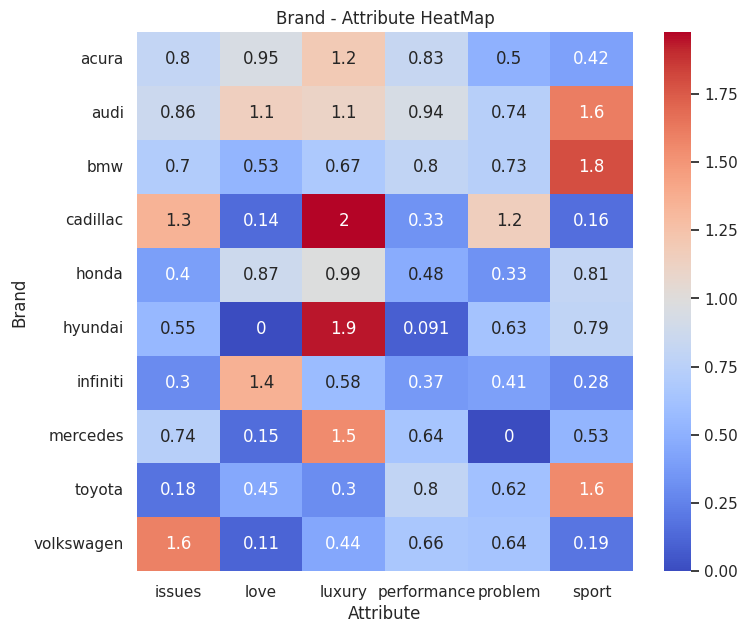

In [26]:
# Creating a pivot to plot a HeatMap for Brand vs Attribute
pivot_df = result_df2.pivot_table(index='Brand',columns='Attribute',values='lift',aggfunc='max')
plt.figure(figsize=(8, 7))
sns.heatmap(pivot_df, annot=True, cmap='coolwarm')
plt.title('Brand - Attribute HeatMap')
plt.show()

From the above heatmap, some strongly associated attributes for brands are as follows:
1. BMW - Sport and Performance
2. Audi - Luxury and Sport
3. Acura - Luxury
4. Mercedes - Luxury

#### **Task G:**
**What advice will you give to your client from Task F?**

**COMPETITIVE ANALYSIS FOR LUXURY BRANDS:**

**Acura - Honda:**

Insight: Acura is perceived as a relatively affordable luxury brand with a strong association with luxury and decent performance attributes. Honda, as the parent company, benefits from this association with Acura.
Recommendation: For a new luxury brand, competing directly with Acura could be challenging due to their affordability and strong attributes. Consider positioning the brand as a more premium and performance-focused alternative while maintaining affordability.

**Audi:**

Insight: Audi is known for exceptional performance and power, making it a top-performing luxury brand. It also has a strong association with luxury and a competitive price.
Recommendation: To compete with Audi, focus on performance and luxury attributes. Emphasize high-performance features while offering competitive pricing to attract customers seeking a blend of luxury and performance.

**BMW:**

Insight: BMW is recognized for performance but lags in luxury perception compared to Audi and Acura. It is also perceived as relatively expensive.
Recommendation: Differentiate by enhancing luxury attributes and communicating the brand's commitment to luxury. Offer competitive pricing compared to BMW while maintaining performance standards.  


**Recommendations to Enter the Luxury Car Market:**

**Affordable Luxury:** Emulate Volkswagen and Acura's approach by offering affordable luxury options. Aim to compete on pricing while maintaining quality and performance standards. Consider providing financing options to make luxury cars more accessible.

**High-Performance Affordability:** Capitalize on the demand for high-performance luxury cars at affordable prices. Target customers who seek the thrill of driving without the premium price tag.

**Enhanced Luxury:** If budget allows, invest in enhancing luxury attributes, as seen in Audi and BMW. Develop a strong brand identity around luxury and use advanced features and materials to differentiate from competitors.


#### **Task H:**
Which is the most aspirational brand in your data in terms of people actually wanting to buy or own? Describe your analysis. What are the business implications for this brand?

In [27]:
pivot_df['Final_Score'] = -pivot_df['issues'] + pivot_df['love'] + pivot_df['luxury'] + pivot_df['performance'] - pivot_df['problem'] + pivot_df['sport']

# Sort the DataFrame by 'Final_Score' in descending order
pivot_df_sorted = pivot_df.sort_values(by='Final_Score', ascending=False)
pivot_df_sorted

Attribute,issues,love,luxury,performance,problem,sport,Final_Score
Brand,,,,,,,
audi,0.861529,1.146125,1.106659,0.938174,0.737884,1.609304,3.200848
honda,0.401162,0.867232,0.985800,0.476565,0.329845,0.806999,2.405588
bmw,0.703284,0.529062,0.673333,0.795689,0.734293,1.796523,2.357030
toyota,0.180096,0.449229,0.301746,0.802302,0.616997,1.552675,2.308859
mercedes,0.740068,0.153834,1.549954,0.641062,0.000000,0.531699,2.136482
acura,0.802959,0.945808,1.195854,0.828024,0.504328,0.416638,2.079036
infiniti,0.295704,1.352264,0.578018,0.365921,0.405224,0.283263,1.878539
hyundai,0.549050,0.000000,1.942050,0.090590,0.627002,0.788927,1.645515
cadillac,1.347586,0.140058,1.975613,0.333516,1.154183,0.161361,0.108779


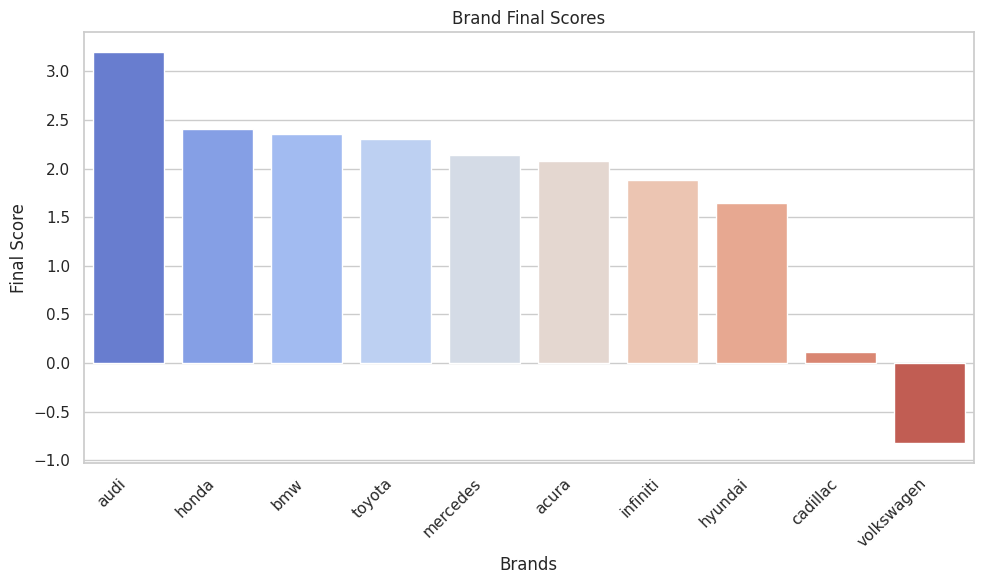

In [28]:
# Create the bar plot using Seaborn
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.barplot(x=pivot_df_sorted.index, y=pivot_df_sorted['Final_Score'], palette='coolwarm')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.xlabel('Brands')
plt.ylabel('Final Score')
plt.title('Brand Final Scores')
plt.tight_layout()  # Ensure labels are not cut off
plt.show()

Given a brand we summed the lift scores of words with a positive sentiment (not considering negator words or phrases) and subtracted the lift scores of the words with a negative sentiment.

**Analysis:**

* Among the luxury car brands analyzed, Audi stands out as the most aspirational brand.  
* Audi received notably high scores for attributes like 'love,' 'luxury','performance,' and 'sport,' indicating that customers have a strong positive sentiment and desire for these aspects in Audi vehicles.  
* Honda and Toyota are in top 5 which makes sense as they have a huge share in the market for their quality and prices.  

**Business Implications:**

* **Audi** should capitalize on its aspirational status by designing marketing campaigns that highlight the brand's desirability, luxury, and high-performance attributes. Additionally audi should try and minimize the issues and problems so that it can build a great barrier for any brand to reach it's position
* **Acura's** affordability combined with positive sentiment suggests an opportunity to target customers seeking affordable luxury.  
* **Volkswagen** should focus on addressing issues and improving overall customer sentiment.

